# exp69_reinit_acdc: Compare Normal vs Random Reinit vs Rewind

This notebook plots:
- Mean Dice vs model size (% of baseline) for the three pruned variants, before and after retraining.
- Three retraining curves in one figure (train loss, val Dice, val IoU), overlaid for all variants.


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import sys
_cwd = Path.cwd().resolve()
_project_root = next((p for p in (_cwd, *_cwd.parents) if (p / "src").exists()), None)
if _project_root is not None and str(_project_root) not in sys.path:
    sys.path.insert(0, str(_project_root))

from src.analysis.plot_style import PUB_COLORS, apply_publication_style, despine

apply_publication_style()


In [2]:
# Paths
exp_dir = Path('/mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp69_reinit_acdc')

variant_tags = {
    'normal': 'l1_norm_50_50_50_50_50_50_50_50_50_50_50',
    'random reinit': 'l1_norm_50_50_50_50_50_50_50_50_50_50_50_random',
    'rewind': 'l1_norm_50_50_50_50_50_50_50_50_50_50_50_rewind',
}

baseline_eval_path = exp_dir / 'baseline' / 'evaluation' / 'run_summary.json'

variant_paths = {}
for variant, tag in variant_tags.items():
    variant_paths[variant] = {
        'pruned_eval': exp_dir / 'pruned' / tag / 'pruned_evaluation' / 'run_summary.json',
        'retrained_eval': exp_dir / 'pruned' / tag / 'retrained_pruned_evaluation' / 'run_summary.json',
        'metrics_epoch': exp_dir / 'pruned' / tag / 'retraining_pruned' / 'metrics_per_epoch.json',
    }

required = [baseline_eval_path]
for v in variant_paths.values():
    required.extend(v.values())

for p in required:
    if not p.exists():
        raise FileNotFoundError(f'Missing file: {p}')


In [3]:
def load_json(path: Path):
    with open(path, 'r') as f:
        return json.load(f)

def extract_eval_row(d: dict, variant: str, stage: str):
    params_m = d.get('profile', {}).get('params_m')
    dice = d.get('eval', {}).get('foreground', {}).get('dice_mean')
    return {
        'variant': variant,
        'stage': stage,
        'params_m': params_m,
        'dice': dice,
    }

baseline_eval = load_json(baseline_eval_path)
rows = [extract_eval_row(baseline_eval, 'baseline', 'baseline')]

for variant, paths in variant_paths.items():
    pruned_eval = load_json(paths['pruned_eval'])
    retrained_eval = load_json(paths['retrained_eval'])
    rows.append(extract_eval_row(pruned_eval, variant, 'before retraining'))
    rows.append(extract_eval_row(retrained_eval, variant, 'after retraining'))

eval_df = pd.DataFrame(rows)
baseline_params = float(eval_df.loc[eval_df['stage'] == 'baseline', 'params_m'].iloc[0])
eval_df['model_size_pct'] = 100.0 * eval_df['params_m'] / baseline_params
eval_df


,variant,stage,params_m,dice,model_size_pct
0,baseline,baseline,43.886340,0.857889,100.000000
1,normal,before retraining,10.976132,0.118030,25.010361
2,normal,after retraining,10.976132,0.860792,25.010361
3,random reinit,before retraining,10.976132,0.068231,25.010361
4,random reinit,after retraining,10.976132,0.830784,25.010361
5,rewind,before retraining,10.976132,0.118030,25.010361
6,rewind,after retraining,10.976132,0.848736,25.010361


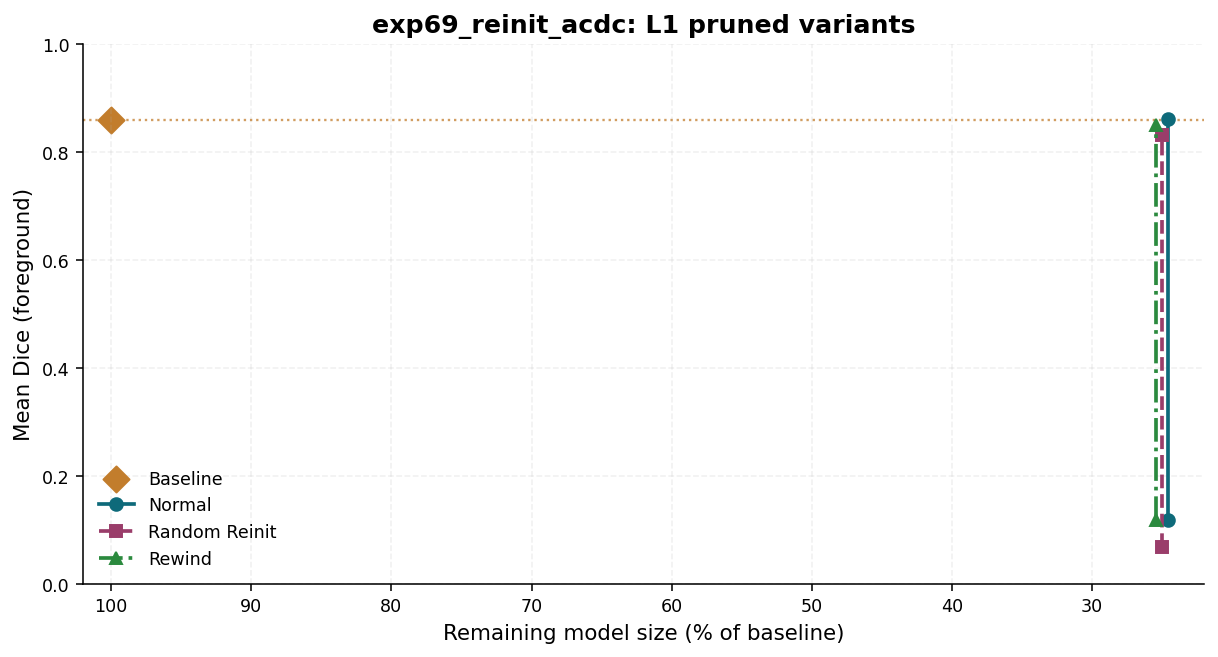

In [4]:
# Figure 1: Dice vs model size for normal/random/rewind (before and after retraining)
fig, ax = plt.subplots(figsize=(8.8, 4.8))

variant_style = {
    'normal': {'color': PUB_COLORS['l1'], 'linestyle': '-', 'marker': 'o', 'offset': -0.45},
    'random reinit': {'color': PUB_COLORS['corr'], 'linestyle': '--', 'marker': 's', 'offset': 0.0},
    'rewind': {'color': PUB_COLORS['good'], 'linestyle': '-.', 'marker': '^', 'offset': 0.45},
}
stage_order = ['before retraining', 'after retraining']

baseline_row = eval_df[eval_df['stage'] == 'baseline'].iloc[0]
ax.scatter(
    baseline_row['model_size_pct'],
    baseline_row['dice'],
    s=90,
    color=PUB_COLORS['neutral'],
    marker='D',
    label='Baseline',
)
ax.axhline(baseline_row['dice'], color=PUB_COLORS['neutral'], linestyle=':', linewidth=1.2, alpha=0.75)

for variant, style in variant_style.items():
    subset = eval_df[(eval_df['variant'] == variant) & (eval_df['stage'].isin(stage_order))].copy()
    subset['stage'] = pd.Categorical(subset['stage'], categories=stage_order, ordered=True)
    subset = subset.sort_values('stage')

    x = subset['model_size_pct'] + style['offset']
    y = subset['dice']

    ax.plot(
        x,
        y,
        color=style['color'],
        linestyle=style['linestyle'],
        marker=style['marker'],
        linewidth=1.9,
        markersize=6.5,
        label=variant.title(),
    )

ax.set_xlim(102, max(0, eval_df['model_size_pct'].min() - 3))
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Remaining model size (% of baseline)')
ax.set_ylabel('Mean Dice (foreground)')
ax.set_title('exp69_reinit_acdc: L1 pruned variants')
ax.legend(frameon=False, loc='lower left')
despine(ax)
plt.tight_layout()
plt.show()


In [5]:
# Load retraining epoch metrics for all variants
def metrics_to_df(obj):
    if isinstance(obj, list):
        return pd.DataFrame(obj)
    if isinstance(obj, dict):
        return pd.DataFrame(obj)
    raise TypeError(f'Unsupported metrics format: {type(obj)}')

metrics_by_variant = {}
for variant, paths in variant_paths.items():
    metrics_obj = load_json(paths['metrics_epoch'])
    metrics_by_variant[variant] = metrics_to_df(metrics_obj)

pd.DataFrame({k: [len(v), int(v['epoch'].min()), int(v['epoch'].max())] for k, v in metrics_by_variant.items()},
             index=['n_epochs', 'epoch_min', 'epoch_max']).T


,n_epochs,epoch_min,epoch_max
normal,40,1,40
random reinit,40,1,40
rewind,40,1,40


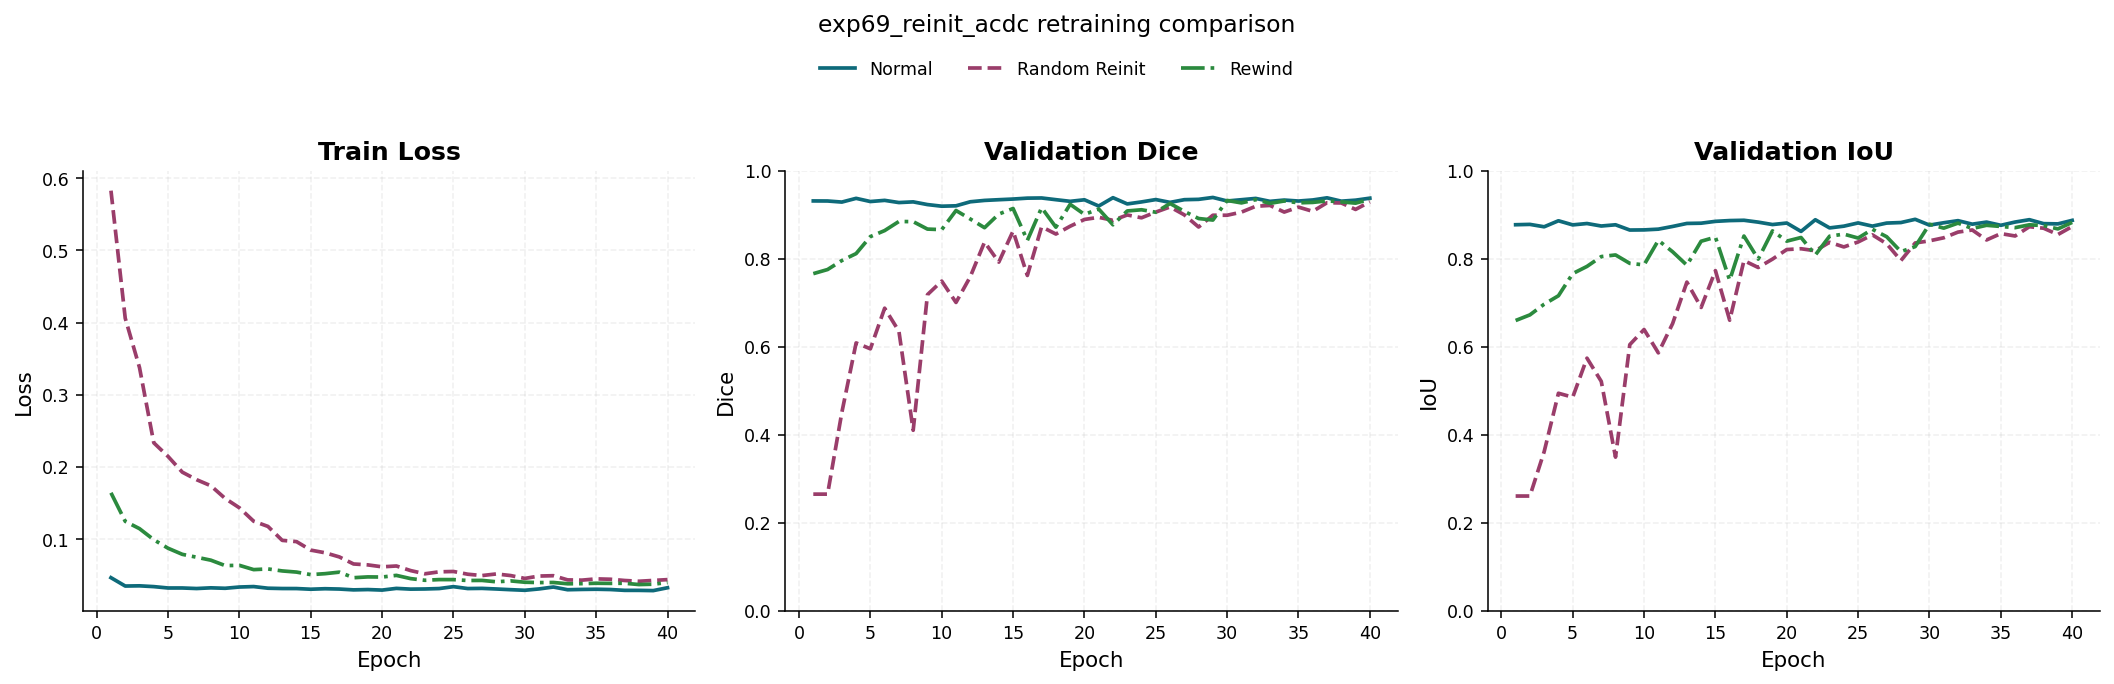

In [6]:
# Figure 2: Three training plots with all variants overlaid
fig, axes = plt.subplots(1, 3, figsize=(15.2, 4.4), sharex=True)

variant_style = {
    'normal': {'color': PUB_COLORS['l1'], 'linestyle': '-'},
    'random reinit': {'color': PUB_COLORS['corr'], 'linestyle': '--'},
    'rewind': {'color': PUB_COLORS['good'], 'linestyle': '-.'},
}

for variant, style in variant_style.items():
    df = metrics_by_variant[variant]

    axes[0].plot(df['epoch'], df['train_loss_mean'], color=style['color'], linestyle=style['linestyle'], linewidth=1.9, label=variant.title())
    axes[1].plot(df['epoch'], df['val_dice_mean'], color=style['color'], linestyle=style['linestyle'], linewidth=1.9, label=variant.title())
    axes[2].plot(df['epoch'], df['val_iou_mean'], color=style['color'], linestyle=style['linestyle'], linewidth=1.9, label=variant.title())

axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
despine(axes[0])

axes[1].set_title('Validation Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')
axes[1].set_ylim(0, 1)
despine(axes[1])

axes[2].set_title('Validation IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')
axes[2].set_ylim(0, 1)
despine(axes[2])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.05))
fig.suptitle('exp69_reinit_acdc retraining comparison', y=1.10)
plt.tight_layout()
plt.show()
